In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 59.0 MB/s eta 0:00:00


In [ ]:
#install all the packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
#Get the path to the directory
input_path = '/content/drive/My Drive/AMLProject/Data/2024-flame-ai-challenge/dataset'

output_path = '/content/drive/My Drive/AMLProject/Data/2024-flame-ai-challenge'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#this class is used to prepare data for the model using the sligin window approach
class WildfireDataset(Dataset):
    def __init__(self, csv_file, data_dir, sequence_length=5, prediction_length=20):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.max_u = self.data['u'].max()
        self.max_alpha = self.data['alpha'].max()

        # Calculate total number of sequences
        self.sequences_per_file = 150 - sequence_length - prediction_length + 1
        self.total_sequences = len(self.data) * self.sequences_per_file

    def __len__(self):
        return self.total_sequences

    def __getitem__(self, idx):
        # Calculate which file and which sequence within the file
        file_idx = idx // self.sequences_per_file
        sequence_start = idx % self.sequences_per_file

        row = self.data.iloc[file_idx]

        # Load data
        ustar = np.fromfile(f"{self.data_dir+'/train'}/{row['ustar_filename']}", dtype=np.float32).reshape(row['Nt'], row['Nx'], row['Ny'])
        theta = np.fromfile(f"{self.data_dir+'/train'}/{row['theta_filename']}", dtype=np.float32).reshape(row['Nt'], row['Nx'], row['Ny'])
        xi = np.fromfile(f"{self.data_dir+'/train'}/{row['xi_filename']}", dtype=np.float32).reshape(row['Nt'], row['Nx'], row['Ny'])

        # Create global parameter channels for u and alpha which are commom for all timestamps for a given fire
        u_channel = np.full((row['Nt'], 1, row['Nx'], row['Ny']), row['u'], dtype=np.float32)
        alpha_channel = np.full((row['Nt'], 1, row['Nx'], row['Ny']), row['alpha'], dtype=np.float32)

        # Normalize data
        # Add safety check for normalization
        if np.std(ustar) == 0:
          ustar = ustar - np.mean(ustar)  # Only center if std is zero
        else:
          ustar = (ustar - np.mean(ustar)) / np.std(ustar)
        if np.std(theta) == 0:
          theta = theta - np.mean(theta)  # Only center if std is zero
        else:
          theta = (theta - np.mean(theta)) / np.std(theta)

        # Normalize global parameters
        u_channel = u_channel / self.max_u
        alpha_channel = alpha_channel / self.max_alpha

        # Select sequence window
        sequence_end = sequence_start + self.sequence_length
        target_start = sequence_end
        target_end = target_start + self.prediction_length

        # Create input sequence
        ustar_seq = ustar[sequence_start:sequence_end]
        theta_seq = theta[sequence_start:sequence_end]
        xi_seq = xi[sequence_start:sequence_end]
        u_seq = u_channel[sequence_start:sequence_end]
        alpha_seq = alpha_channel[sequence_start:sequence_end]

        # Stack input channels
        input_seq = np.stack([ustar_seq, theta_seq, xi_seq], axis=1)

        # Add positional encoding
        pos_enc = self.positional_encoding(self.sequence_length, row['Nx'], row['Ny'])

        # Concatenate all channels
        input_seq = np.concatenate([input_seq, pos_enc, u_seq, alpha_seq], axis=1)

        # Create target sequence
        if target_end <= 150:
            target = xi[target_start:target_end]
        else:
            # Pad with zeros if target extends beyond available timesteps
            available_steps = 150 - target_start
            target = np.zeros((self.prediction_length, row['Nx'], row['Ny']), dtype=np.float32)
            if available_steps > 0:
                target[:available_steps] = xi[target_start:150]

        return torch.FloatTensor(input_seq), torch.FloatTensor(target)
#the idea and part of the code for positional encoding waas taken from the second best solution in the kaggle competition - https://www.kaggle.com/competitions/2024-flame-ai-challenge/discussion/541458
    def positional_encoding(self, seq_len, height, width):
        pos_enc = np.zeros((seq_len, 2, height, width), dtype=np.float32)
        for t in range(seq_len):
            for i in range(height):
                for j in range(width):
                    pos_enc[t, 0, i, j] = i / height
                    pos_enc[t, 1, i, j] = j / width
        return pos_enc

In [ ]:
#perplexity waas used in coding this part
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [ ]:
class WildfireModel(pl.LightningModule):
    def __init__(self, input_dim=7, hidden_dim=7, kernel_size=(3, 3), num_layers=3):
        super(WildfireModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers

        # Initialize loss tracking lists
        self.epoch_train_losses = []
        self.epoch_val_losses = []

        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim,
                                          kernel_size=self.kernel_size,
                                          bias=True))
        self.cell_list = nn.ModuleList(cell_list)
        self.conv_output = nn.Conv2d(in_channels=self.hidden_dim,
                                     out_channels=1,
                                     kernel_size=(1, 1),
                                     bias=True)
        self.validation_step_outputs = []

    def forward(self, x, future_steps):
        b, t, c, h, w = x.size()
        hidden_state = self.init_hidden(batch_size=b, image_size=(h, w))
        outputs = []

        # Process input sequence to get final hidden state
        for i in range(t):
            input_tensor = x[:, i, :, :, :]
            for layer_idx in range(self.num_layers):
                h, c = hidden_state[layer_idx]
                h, c = self.cell_list[layer_idx](input_tensor=input_tensor, cur_state=[h, c])
                input_tensor = h
                hidden_state[layer_idx] = (h, c)

        # Only store predictions for future timesteps
        for _ in range(future_steps):
            for layer_idx in range(self.num_layers):
                h, c = hidden_state[layer_idx]
                h, c = self.cell_list[layer_idx](input_tensor=input_tensor, cur_state=[h, c])
                input_tensor = h
                hidden_state[layer_idx] = (h, c)

            output = self.conv_output(h)
            outputs.append(output)

        return torch.stack(outputs, dim=1).squeeze(2)

    def init_hidden(self, batch_size, image_size):
        init_states = []
        for _ in range(self.num_layers):
            init_states.append((torch.zeros(batch_size, self.hidden_dim, image_size[0], image_size[1], device=self.device),
                                torch.zeros(batch_size, self.hidden_dim, image_size[0], image_size[1], device=self.device)))
        return init_states

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, future_steps=y.size(1))
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics['train_loss']
        self.epoch_train_losses.append(train_loss.item())
        print(f"Epoch {self.current_epoch} - Training Loss: {train_loss:.6f}")

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, future_steps=y.size(1))
        loss = F.mse_loss(y_hat, y)
        self.validation_step_outputs.append({
            'val_loss': loss,
            'y': y,
            'y_hat': y_hat
        })
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_start(self):
        self.validation_step_outputs = []

    def on_validation_epoch_end(self):
        if len(self.validation_step_outputs) == 0:
            return

        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.epoch_val_losses.append(avg_loss.item())

        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])

        y_flat = y.view(-1).cpu().numpy()
        y_hat_flat = y_hat.view(-1).cpu().numpy()

        f1 = f1_score((y_flat > 0.5).astype(int), (y_hat_flat > 0.5).astype(int), average='weighted')
        roc_auc = roc_auc_score((y_flat > 0.5).astype(int), y_hat_flat)
        mse = mean_squared_error(y_flat, y_hat_flat)

        print(f"Epoch {self.current_epoch}")
        print(f"Validation Loss: {avg_loss:.6f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"MSE: {mse:.6f}")
        print("-" * 50)

        self.log('val_f1', f1)
        self.log('val_roc_auc', roc_auc)
        self.log('val_mse', mse)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(os.path.join(input_path, 'train.csv'))

In [ ]:
# 7. Initialize dataset and create data loaders
train_dataset = WildfireDataset(
    csv_file=os.path.join(input_path, 'train.csv'),
    data_dir=input_path,
    sequence_length=5,
    prediction_length=20
)

# 8. Create train-validation split and data loaders
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
print(train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/My Drive/AMLProject/Data/2024-flame-ai-challenge/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0
Validation Loss: 0.100138
F1 Score: 0.9597
ROC AUC: 0.6494
MSE: 0.100138
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0
Validation Loss: 0.025757
F1 Score: 0.9611
ROC AUC: 0.7490
MSE: 0.025806
--------------------------------------------------
Epoch 0 - Training Loss: 0.024809


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1
Validation Loss: 0.024413
F1 Score: 0.9611
ROC AUC: 0.7844
MSE: 0.024537
--------------------------------------------------
Epoch 1 - Training Loss: 0.025203


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2
Validation Loss: 0.023915
F1 Score: 0.9611
ROC AUC: 0.8144
MSE: 0.024025
--------------------------------------------------
Epoch 2 - Training Loss: 0.024822


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3
Validation Loss: 0.023213
F1 Score: 0.9611
ROC AUC: 0.8476
MSE: 0.023367
--------------------------------------------------
Epoch 3 - Training Loss: 0.023197


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4
Validation Loss: 0.021903
F1 Score: 0.9611
ROC AUC: 0.8877
MSE: 0.022007
--------------------------------------------------
Epoch 4 - Training Loss: 0.020527


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5
Validation Loss: 0.018537
F1 Score: 0.9611
ROC AUC: 0.9494
MSE: 0.018538
--------------------------------------------------
Epoch 5 - Training Loss: 0.018638


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6
Validation Loss: 0.016408
F1 Score: 0.9682
ROC AUC: 0.9596
MSE: 0.016566
--------------------------------------------------
Epoch 6 - Training Loss: 0.017792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7
Validation Loss: 0.016506
F1 Score: 0.9730
ROC AUC: 0.9641
MSE: 0.016700
--------------------------------------------------
Epoch 7 - Training Loss: 0.017500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8
Validation Loss: 0.014816
F1 Score: 0.9764
ROC AUC: 0.9809
MSE: 0.014955
--------------------------------------------------
Epoch 8 - Training Loss: 0.012304


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9
Validation Loss: 0.014246
F1 Score: 0.9775
ROC AUC: 0.9727
MSE: 0.014422
--------------------------------------------------
Epoch 9 - Training Loss: 0.013366


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10
Validation Loss: 0.013450
F1 Score: 0.9796
ROC AUC: 0.9831
MSE: 0.013480
--------------------------------------------------
Epoch 10 - Training Loss: 0.013593


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11
Validation Loss: 0.012763
F1 Score: 0.9810
ROC AUC: 0.9833
MSE: 0.012823
--------------------------------------------------
Epoch 11 - Training Loss: 0.013394


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12
Validation Loss: 0.013766
F1 Score: 0.9787
ROC AUC: 0.9807
MSE: 0.013852
--------------------------------------------------
Epoch 12 - Training Loss: 0.013295


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13
Validation Loss: 0.012276
F1 Score: 0.9815
ROC AUC: 0.9862
MSE: 0.012242
--------------------------------------------------
Epoch 13 - Training Loss: 0.015487


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14
Validation Loss: 0.012772
F1 Score: 0.9815
ROC AUC: 0.9870
MSE: 0.012644
--------------------------------------------------
Epoch 14 - Training Loss: 0.012838


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15
Validation Loss: 0.011886
F1 Score: 0.9824
ROC AUC: 0.9876
MSE: 0.011857
--------------------------------------------------
Epoch 15 - Training Loss: 0.011380


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16
Validation Loss: 0.011921
F1 Score: 0.9822
ROC AUC: 0.9875
MSE: 0.011927
--------------------------------------------------
Epoch 16 - Training Loss: 0.011791


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17
Validation Loss: 0.011978
F1 Score: 0.9826
ROC AUC: 0.9885
MSE: 0.011907
--------------------------------------------------
Epoch 17 - Training Loss: 0.012952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18
Validation Loss: 0.011417
F1 Score: 0.9834
ROC AUC: 0.9894
MSE: 0.011364
--------------------------------------------------
Epoch 18 - Training Loss: 0.012082


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19
Validation Loss: 0.011426
F1 Score: 0.9835
ROC AUC: 0.9897
MSE: 0.011392
--------------------------------------------------
Epoch 19 - Training Loss: 0.014003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20
Validation Loss: 0.011395
F1 Score: 0.9836
ROC AUC: 0.9894
MSE: 0.011350
--------------------------------------------------
Epoch 20 - Training Loss: 0.013365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21
Validation Loss: 0.011465
F1 Score: 0.9835
ROC AUC: 0.9894
MSE: 0.011446
--------------------------------------------------
Epoch 21 - Training Loss: 0.011005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22
Validation Loss: 0.011107
F1 Score: 0.9839
ROC AUC: 0.9899
MSE: 0.011077
--------------------------------------------------
Epoch 22 - Training Loss: 0.009873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23
Validation Loss: 0.011039
F1 Score: 0.9840
ROC AUC: 0.9901
MSE: 0.011005
--------------------------------------------------
Epoch 23 - Training Loss: 0.013092


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24
Validation Loss: 0.011324
F1 Score: 0.9837
ROC AUC: 0.9897
MSE: 0.011291
--------------------------------------------------
Epoch 24 - Training Loss: 0.010046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25
Validation Loss: 0.011163
F1 Score: 0.9837
ROC AUC: 0.9899
MSE: 0.011153
--------------------------------------------------
Epoch 25 - Training Loss: 0.011268


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26
Validation Loss: 0.011420
F1 Score: 0.9835
ROC AUC: 0.9897
MSE: 0.011421
--------------------------------------------------
Epoch 26 - Training Loss: 0.009900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27
Validation Loss: 0.011648
F1 Score: 0.9830
ROC AUC: 0.9853
MSE: 0.011646
--------------------------------------------------
Epoch 27 - Training Loss: 0.009026


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28
Validation Loss: 0.010889
F1 Score: 0.9843
ROC AUC: 0.9886
MSE: 0.010861
--------------------------------------------------
Epoch 28 - Training Loss: 0.009927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29
Validation Loss: 0.010986
F1 Score: 0.9842
ROC AUC: 0.9901
MSE: 0.010956
--------------------------------------------------
Epoch 29 - Training Loss: 0.012765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30
Validation Loss: 0.011633
F1 Score: 0.9829
ROC AUC: 0.9825
MSE: 0.011599
--------------------------------------------------
Epoch 30 - Training Loss: 0.011426


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31
Validation Loss: 0.010927
F1 Score: 0.9842
ROC AUC: 0.9855
MSE: 0.010925
--------------------------------------------------
Epoch 31 - Training Loss: 0.012996


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32
Validation Loss: 0.010736
F1 Score: 0.9846
ROC AUC: 0.9906
MSE: 0.010704
--------------------------------------------------
Epoch 32 - Training Loss: 0.010578


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33
Validation Loss: 0.010737
F1 Score: 0.9847
ROC AUC: 0.9908
MSE: 0.010709
--------------------------------------------------
Epoch 33 - Training Loss: 0.010810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34
Validation Loss: 0.010673
F1 Score: 0.9847
ROC AUC: 0.9905
MSE: 0.010640
--------------------------------------------------
Epoch 34 - Training Loss: 0.010344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35
Validation Loss: 0.011054
F1 Score: 0.9839
ROC AUC: 0.9874
MSE: 0.011038
--------------------------------------------------
Epoch 35 - Training Loss: 0.010342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36
Validation Loss: 0.010672
F1 Score: 0.9847
ROC AUC: 0.9893
MSE: 0.010646
--------------------------------------------------
Epoch 36 - Training Loss: 0.010787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37
Validation Loss: 0.010623
F1 Score: 0.9847
ROC AUC: 0.9910
MSE: 0.010588
--------------------------------------------------
Epoch 37 - Training Loss: 0.010247


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38
Validation Loss: 0.010586
F1 Score: 0.9847
ROC AUC: 0.9904
MSE: 0.010553
--------------------------------------------------
Epoch 38 - Training Loss: 0.010499


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39
Validation Loss: 0.010783
F1 Score: 0.9845
ROC AUC: 0.9909
MSE: 0.010764
--------------------------------------------------
Epoch 39 - Training Loss: 0.011136


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40
Validation Loss: 0.010623
F1 Score: 0.9848
ROC AUC: 0.9907
MSE: 0.010592
--------------------------------------------------
Epoch 40 - Training Loss: 0.009854


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41
Validation Loss: 0.010740
F1 Score: 0.9846
ROC AUC: 0.9899
MSE: 0.010696
--------------------------------------------------
Epoch 41 - Training Loss: 0.008175


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42
Validation Loss: 0.010643
F1 Score: 0.9848
ROC AUC: 0.9911
MSE: 0.010606
--------------------------------------------------
Epoch 42 - Training Loss: 0.010445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43
Validation Loss: 0.010542
F1 Score: 0.9848
ROC AUC: 0.9904
MSE: 0.010512
--------------------------------------------------
Epoch 43 - Training Loss: 0.010756


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44
Validation Loss: 0.010607
F1 Score: 0.9847
ROC AUC: 0.9908
MSE: 0.010569
--------------------------------------------------
Epoch 44 - Training Loss: 0.010189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45
Validation Loss: 0.010635
F1 Score: 0.9849
ROC AUC: 0.9911
MSE: 0.010593
--------------------------------------------------
Epoch 45 - Training Loss: 0.008727


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46
Validation Loss: 0.010532
F1 Score: 0.9849
ROC AUC: 0.9915
MSE: 0.010497
--------------------------------------------------
Epoch 46 - Training Loss: 0.011140


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47
Validation Loss: 0.010604
F1 Score: 0.9848
ROC AUC: 0.9904
MSE: 0.010574
--------------------------------------------------
Epoch 47 - Training Loss: 0.011140


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48
Validation Loss: 0.010661
F1 Score: 0.9846
ROC AUC: 0.9902
MSE: 0.010623
--------------------------------------------------
Epoch 48 - Training Loss: 0.009996


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49
Validation Loss: 0.010471
F1 Score: 0.9850
ROC AUC: 0.9915
MSE: 0.010441
--------------------------------------------------
Epoch 49 - Training Loss: 0.009248


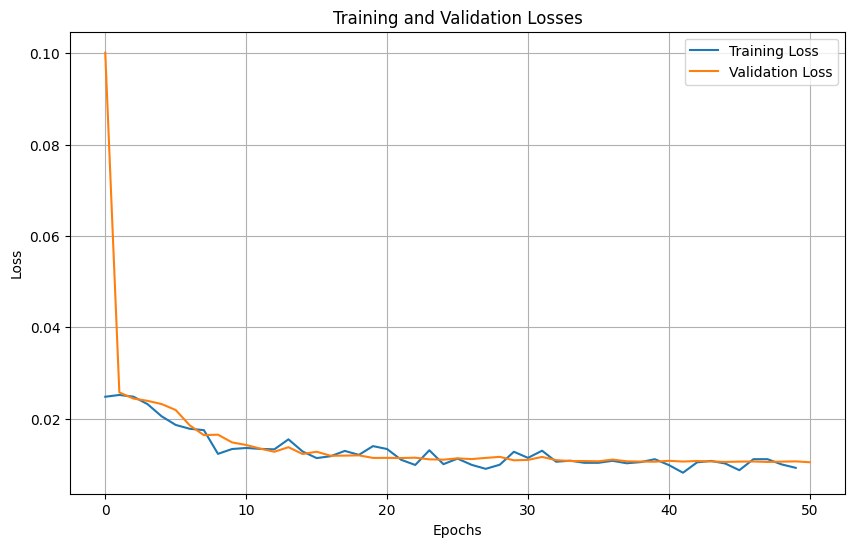

In [ ]:
# 9. Initialize and train model
model = WildfireModel(
    input_dim=7,  # Total channels from data
    hidden_dim=7,  # Reduced to prevent channel mismatch
    kernel_size=(3, 3),
    num_layers=3
)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(output_path, 'checkpoints'),
    filename='wildfire-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    monitor='val_loss',
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[checkpoint_callback],
    default_root_dir=output_path
)

def plot_training_history(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.epoch_train_losses, label='Training Loss')
    plt.plot(model.epoch_val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# 10. Start training
# After training
trainer.fit(model, train_loader, val_loader)
plot_training_history(model)

In [ ]:
#perplexity's assistance was used in creating this animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
from google.colab import files

def create_and_save_fire_animation(model, test_loader, filename=None):
    x_test, y_test = next(iter(test_loader))
    x = x_test[0:1]
    y_true = y_test[0]

    with torch.no_grad():
        y_pred = model(x, future_steps=y_true.size(0))
        y_pred = y_pred[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Create imshow objects once
    im1 = ax1.imshow(y_true[0].cpu(), cmap='hot', vmin=0, vmax=1)
    im2 = ax2.imshow(y_pred[0].cpu(), cmap='hot', vmin=0, vmax=1)

    # Create colorbars once
    fig.colorbar(im1, ax=ax1)
    fig.colorbar(im2, ax=ax2)

    def update(frame):
        im1.set_array(y_true[frame].cpu())
        im2.set_array(y_pred[frame].cpu())
        ax1.set_title(f'Actual Fire (t={frame})')
        ax2.set_title(f'Predicted Fire (t={frame})')
        return im1, im2

    anim = animation.FuncAnimation(
        fig, update, frames=y_true.size(0),
        interval=200, blit=True
    )

    if filename:
        if filename.endswith('.mp4'):
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
            anim.save(filename, writer=writer)
            files.download(filename)
        elif filename.endswith('.gif'):
            anim.save(filename, writer='pillow')
            files.download(filename)

    plt.close()
    return anim

# Create and save animations
anim_gif = create_and_save_fire_animation(model, val_loader, 'fire_prediction.gif')

# Display in notebook
HTML(anim_gif.to_jshtml())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>